# Dataset - Snapshot Karoo
The Karoo National Park is a wildlife reserve in the Great Karoo area of the Western Cape, South Africa near Beaufort West. This semi-desert area covers an area of 750 square kilometres.

The Karoo National Park is a sanctuary for herds of springbok, gemsbok (or Oryx),black wildebeest Cape mountain zebra, red hartebeest, black rhinoceros, eland, kudu, klipspringer, bat-eared foxes, black-backed jackal, ostriches, and, since fairly recently, lions.

This data set contains 14889 sequences of camera trap images, totaling 38074 images, from the Snapshot Karoo project, part of the Snapshot Safari network.

Labels are provided for 38 categories, primarily at the species level (for example, the most common labels are gemsbokoryx, hartebeestred, and kudu). Approximately 83.02% of images are labeled as empty.

https://lila.science/datasets/snapshot-karoo

In [ ]:
# import any necessary libraries
import os
import json
from os import listdir
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
import random
import math
from PIL import Image
import PIL

import torch
import torchvision
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes

import skimage as ski
from natsort import natsorted, ns

from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn import svm, model_selection, metrics
from statistics import mean, stdev
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing

from imblearn.over_sampling import SMOTE
from collections import Counter
from joblib import dump, load

# Task 1: Data Selection, Loading
Task is to load the dataset using Python, including the images and the annotations, so that it can be passed into the model.

Certain folders corresponding to different Camera Traps were downloaded which includes the following:

1.   A01
2.   A02
3.   D01
4.   D03
5.   D04
6.   E01
7.   E03

The intial dataset downloaded was 2.9GB, containing 2,799 images. This should be reduced further to around 1000 images. Click the link below to access the images.

[Selected Data](https://drive.google.com/drive/folders/1xZzsGW-mqH0Alcv5Y6DyoAvWQT-9YLuk?usp=sharing)

Data ID - 1xZzsGW-mqH0Alcv5Y6DyoAvWQT-9YLuk

https://github.com/watch-raider/snapshot-karoo.git




In [ ]:
# loading data from Github

!git clone https://github.com/watch-raider/snapshot-karoo.git
%ls

Cloning into 'snapshot-karoo'...
remote: Enumerating objects: 2019, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 2019 (delta 0), reused 3 (delta 0), pack-reused 2014
Receiving objects: 100% (2019/2019), 1.90 GiB | 25.51 MiB/s, done.
Resolving deltas: 100% (7/7), done.
Updating files: 100% (1990/1990), done.
sample_data/  snapshot-karoo/


In [ ]:
image_root_path = '/content/snapshot-karoo/KAR_S1'
annotations_path = '/content/snapshot-karoo/SnapshotKaroo_S1_v1.0.json'
camera_traps = ['A01', 'A02', 'D01', 'D03', 'D04', 'E01', 'E03']

# Opening JSON file containing annotations
annotations_json = open(annotations_path)

# returns JSON object as
# a dictionary
annotations_data = json.load(annotations_json)
annotations_data['info']

{'version': '1.0',
 'description': 'Camera trap data from the Snapshot Karoo program',
 'date_created': '2019',
 'contributor': 'Snapshot Safari'}

In [ ]:
# display categories in data
annotations_data['categories']

[{'id': 0, 'name': 'empty'},
 {'id': 1, 'name': 'human'},
 {'id': 2, 'name': 'zebramountain'},
 {'id': 3, 'name': 'baboon'},
 {'id': 4, 'name': 'kudu'},
 {'id': 5, 'name': 'gemsbokoryx'},
 {'id': 6, 'name': 'springbok'},
 {'id': 7, 'name': 'eland'},
 {'id': 8, 'name': 'rhinocerosblack'},
 {'id': 9, 'name': 'ostrich'},
 {'id': 10, 'name': 'rhebokgrey'},
 {'id': 11, 'name': 'hartebeestred'},
 {'id': 12, 'name': 'reedbuckmountain'},
 {'id': 13, 'name': 'steenbok'},
 {'id': 14, 'name': 'zebraburchells'},
 {'id': 15, 'name': 'bustardkori'},
 {'id': 16, 'name': 'birdother'},
 {'id': 17, 'name': 'jackalblackbacked'},
 {'id': 18, 'name': 'duiker'},
 {'id': 19, 'name': 'monkeyvervet'},
 {'id': 20, 'name': 'hare'},
 {'id': 21, 'name': 'wildebeestblue'},
 {'id': 22, 'name': 'caracal'},
 {'id': 23, 'name': 'lionmale'},
 {'id': 24, 'name': 'tortoise'},
 {'id': 25, 'name': 'foxcape'},
 {'id': 26, 'name': 'rabbitriverine'},
 {'id': 27, 'name': 'porcupine'},
 {'id': 28, 'name': 'bustardludwigs'},
 {'i

In [ ]:
all_img_paths = []

# get all image paths for each camera in selected dataset
for camera in camera_traps:
    folder_dir = '{}/{}/{}_R1'.format(image_root_path, camera, camera)
    img_paths = os.listdir(folder_dir)
    all_img_paths += img_paths
    print(camera, len(img_paths))

print('Total', len(all_img_paths))

A01 123
A02 188
D01 180
D03 147
D04 887
E01 248
E03 209
Total 1982


In [ ]:
# retreive annotations for selected images
img_annotations = [x for x in annotations_data['annotations'] if '{}.JPG'.format(x['image_id'].split('/')[-1]) in all_img_paths]
print(len(img_annotations), len(all_img_paths))

# retreive data that will be used from annotations and load into Dataframe
selected_data = [[x['subject_id'], x['image_id'], x['location'], x['category_id'], x['count']] for x in img_annotations]
df = pd.DataFrame(selected_data, columns=['subject_id', 'image_id', 'camera', 'category_id', 'count'])
print(len(df))
df.head()

1993 1982
1993


,subject_id,image_id,camera,category_id,count
0,28794487,KAR_S1/A01/A01_R1/KAR_S1_A01_R1_IMAG00015,A01,2,1
1,28794488,KAR_S1/A01/A01_R1/KAR_S1_A01_R1_IMAG00016,A01,3,1
2,28794489,KAR_S1/A01/A01_R1/KAR_S1_A01_R1_IMAG00017,A01,3,1
3,28794490,KAR_S1/A01/A01_R1/KAR_S1_A01_R1_IMAG00018,A01,4,1
4,28794492,KAR_S1/A01/A01_R1/KAR_S1_A01_R1_IMAG00020,A01,5,1


Categories in dataset [0, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 15, 16, 17, 18, 19, 22, 23, 27, 28, 29, 35, 36, 37]


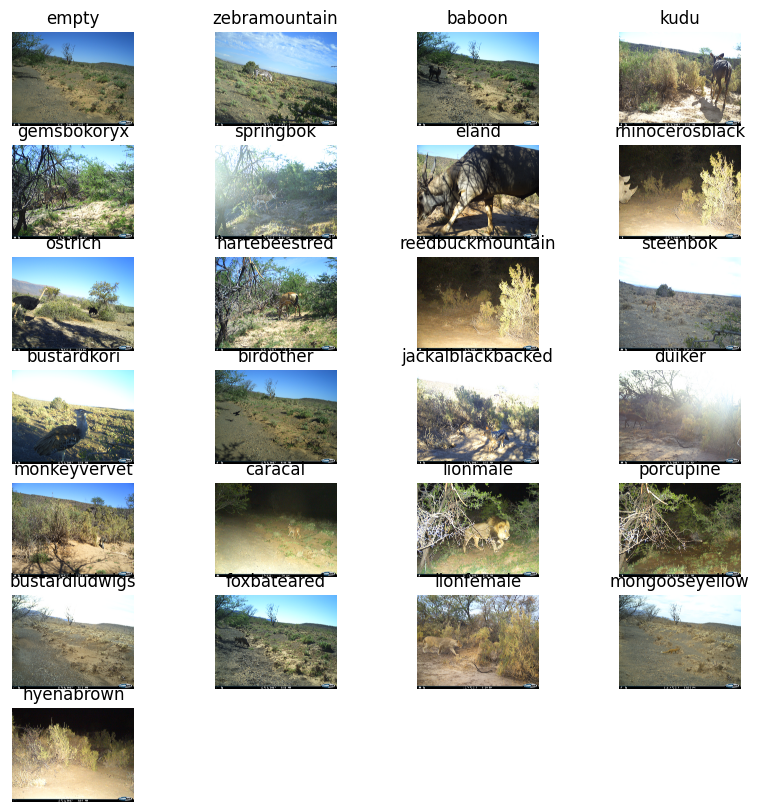

In [ ]:
# Display some images
category_vals = set(df['category_id'].values)
category_vals = list(category_vals)
print('Categories in dataset', category_vals)

figure = plt.figure(figsize=(10, 10))
cols, rows = 4, (len(category_vals) // 4) + 1

category_i = 0
for i in range(1, cols * rows + 1):
    if category_i < len(category_vals):
        images = df[df['category_id'] == category_vals[category_i]]
        # Display different images each time
        random_img_id = random.randint(0, len(images) - 1)
        image = img.imread('/content/snapshot-karoo/{}.JPG'.format(images.iloc[random_img_id]['image_id']))
        figure.add_subplot(rows, cols, i)
        plt.title(annotations_data['categories'][category_vals[category_i]]['name'])
        plt.axis("off")
        plt.imshow(image)
        category_i += 1
    else:
        break

plt.show()

# Task 2: Visualisation
Some visualisation will then need to be performed in order to understand the dataset that has been selected.

Some ideas of what we need:


*   Species make up (number of images for each species)
*   Number images with no animals
*   Number of images for each Camera Trap
*   The species make up for each Camera Trap (e.g. how many Zebras did A01 Camera Trap capture)









In [ ]:
import json
import matplotlib.pyplot as plt

# Load the JSON file
with open('/content/snapshot-karoo/SnapshotKaroo_S1_v1.0.json') as file:
    data = json.load(file)

# Extract categories, annotations, and images
categories = data['categories']
annotations = data['annotations']
images = data['images']



**Pie Chart Of Empty Images**

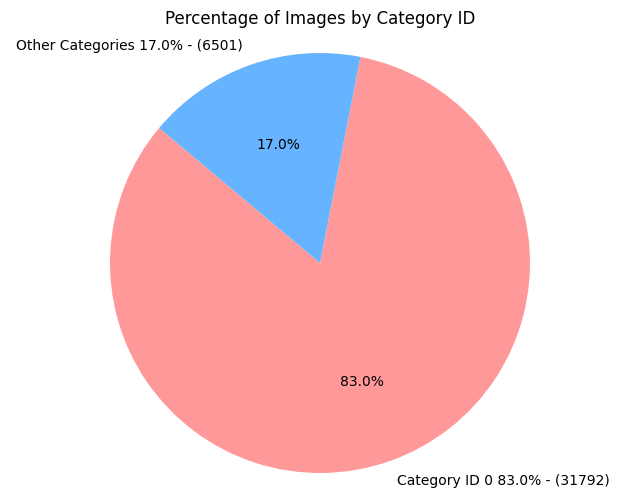

In [ ]:
# Count the number of images with category id 0 and all others
category_0_count = sum(1 for annotation in annotations if annotation['category_id'] == 0)
total_images = len(images)
other_category_count = total_images - category_0_count

# Calculate percentages
category_0_percent = (category_0_count / total_images) * 100
other_category_percent = (other_category_count / total_images) * 100

# Create labels and sizes for the pie chart
labels = ['Category ID 0 {:.1f}% - ({})'.format(category_0_percent, category_0_count),
          'Other Categories {:.1f}% - ({})'.format(other_category_percent, other_category_count)]
sizes = [category_0_count, other_category_count]
colors = ['#ff9999','#66b3ff']  # You can change colors if you want

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Images by Category ID')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

**Creating a dataframe without empty images**

In [ ]:
# Filter annotations where category_id is not 0
filtered_annotations = [annotation for annotation in annotations if annotation['category_id'] != 0]

# Create DataFrame
df_annotations = pd.DataFrame(filtered_annotations)
df_images = pd.DataFrame(images)
# Display the DataFrame
#print(df)
if any(annotation['category_id'] == 0 for annotation in filtered_annotations):
    print("There are objects with category ID of 0.")
else:
    print("There are no objects with category ID of 0.")

There are no objects with category ID of 0.


**Species make up (number of images for each species)**

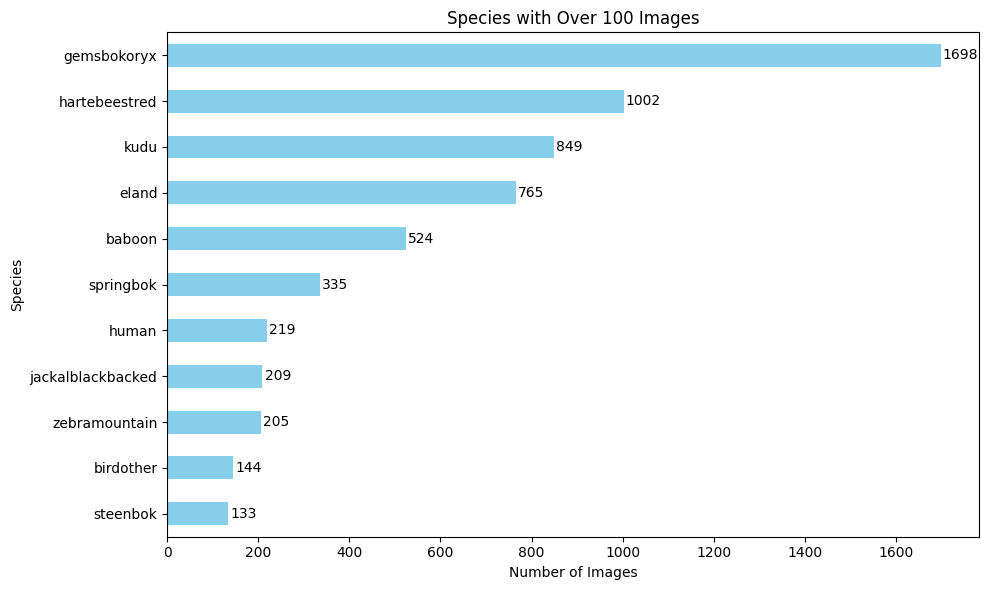

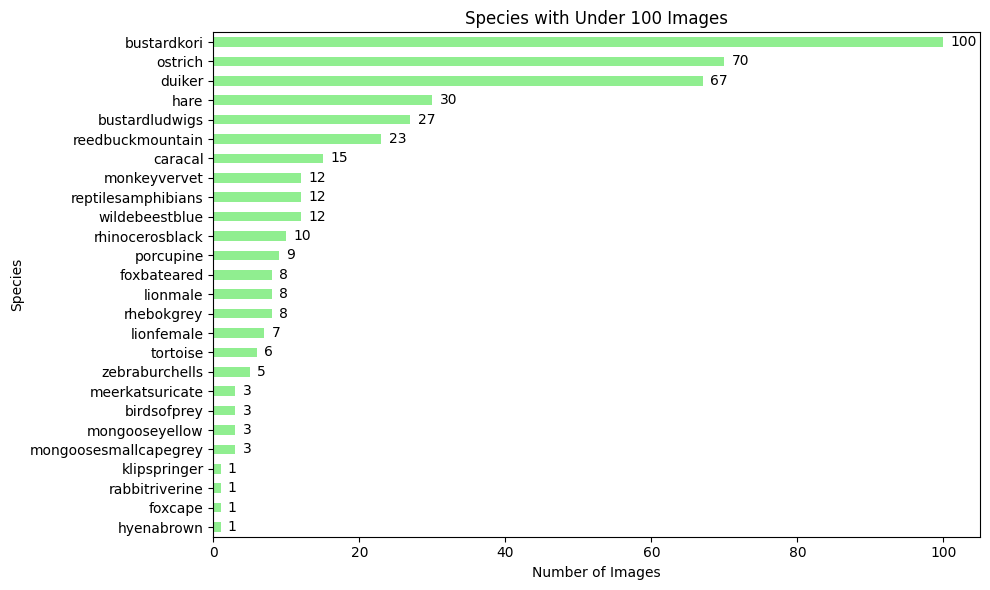

In [ ]:
# Merge annotations and images on image_id
merged_df = pd.merge(df_annotations, df_images, left_on='image_id', right_on='id', how='inner')

# Group by species and count the number of images
species_counts = merged_df.groupby('category_id')['id_y'].count()

# Get species names from categories
species_names = {category['id']: category['name'] for category in data['categories'] if category['id'] != 0}

# Replace category_id with species names
species_counts.index = species_counts.index.map(species_names)

# Sort species_counts
sorted_species_counts = species_counts.sort_values()

# Separate species with over and under 100 images
over_100 = sorted_species_counts[sorted_species_counts > 100]
under_100 = sorted_species_counts[sorted_species_counts <= 100]

# Plotting species with over 100 images
plt.figure(figsize=(10, 6))
over_100.plot(kind='barh', color='skyblue')
for i, v in enumerate(over_100):
    plt.text(v + 5, i, str(v), ha='left', va='center')
plt.xlabel('Number of Images')
plt.ylabel('Species')
plt.title('Species with Over 100 Images')
plt.tight_layout()
plt.show()

# Plotting species with under 100 images
plt.figure(figsize=(10, 6))
under_100.plot(kind='barh', color='lightgreen')
for i, v in enumerate(under_100):
    plt.text(v + 1, i, str(v), ha='left', va='center')
plt.xlabel('Number of Images')
plt.ylabel('Species')
plt.title('Species with Under 100 Images')
plt.tight_layout()
plt.show()

**Number of images for each Camera Trap**

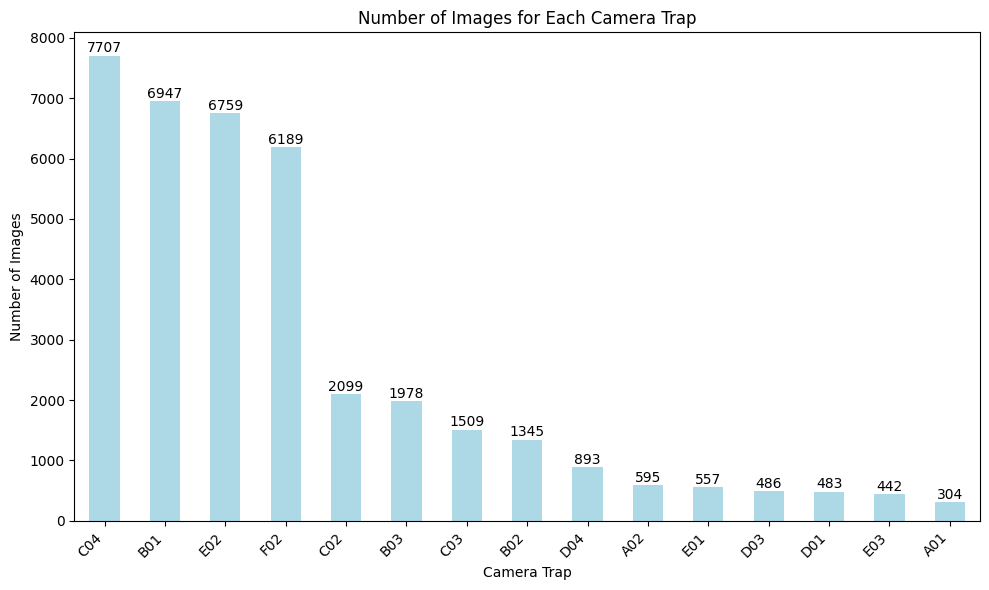

In [ ]:
# Group by camera trap and count the number of images
camera_trap_counts = df_images['location'].value_counts()

# Plotting the bar chart
plt.figure(figsize=(10, 6))
camera_trap_counts.plot(kind='bar', color='lightblue')
for i, v in enumerate(camera_trap_counts):
    plt.text(i, v + 5, str(v), ha='center', va='bottom')
plt.xlabel('Camera Trap')
plt.ylabel('Number of Images')
plt.title('Number of Images for Each Camera Trap')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**The species make up for each Camera Trap (e.g. how many Zebras did A01 Camera Trap capture)**

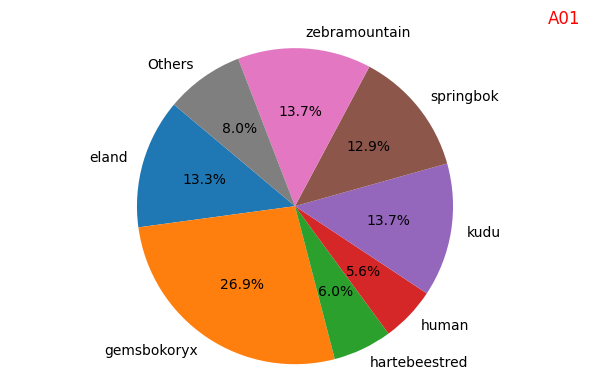

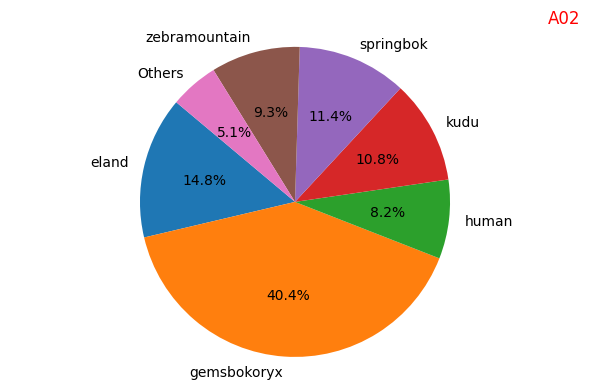

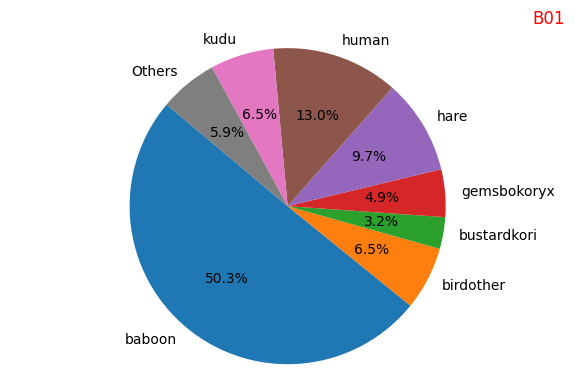

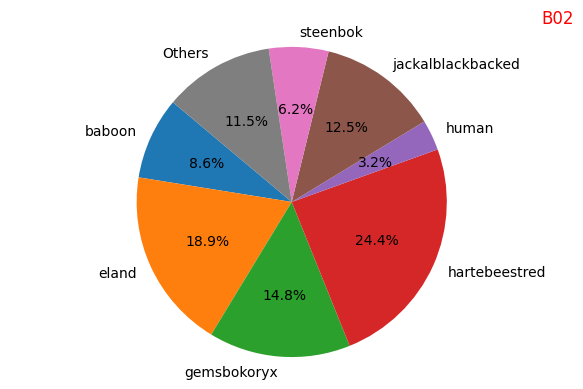

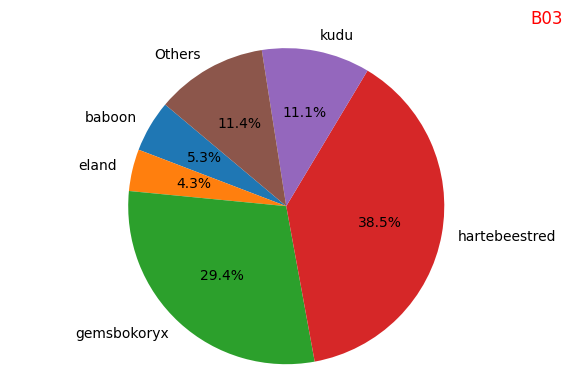

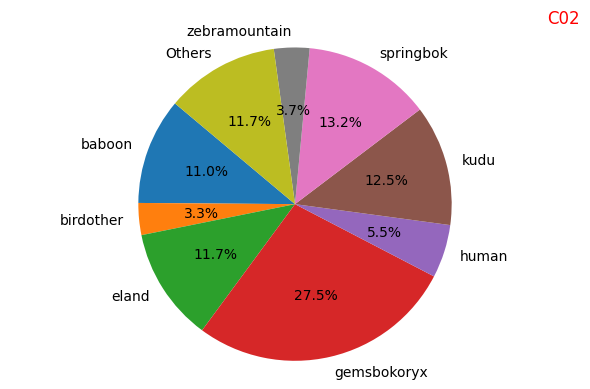

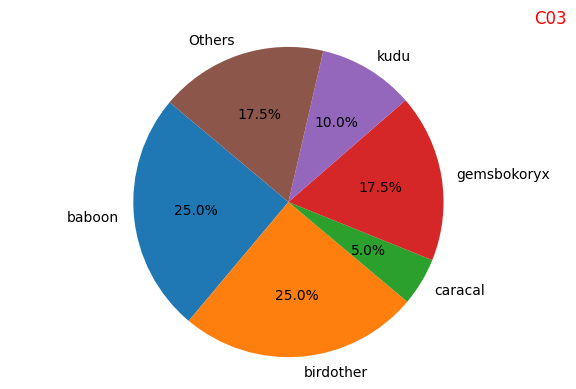

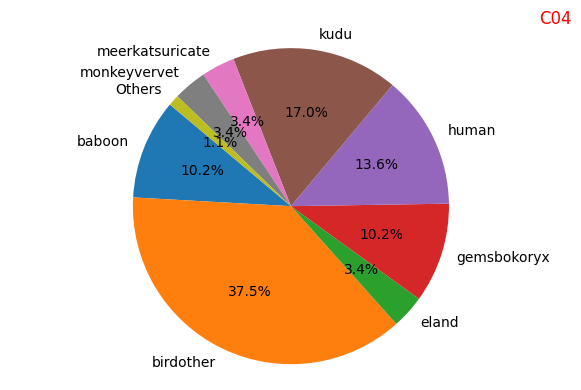

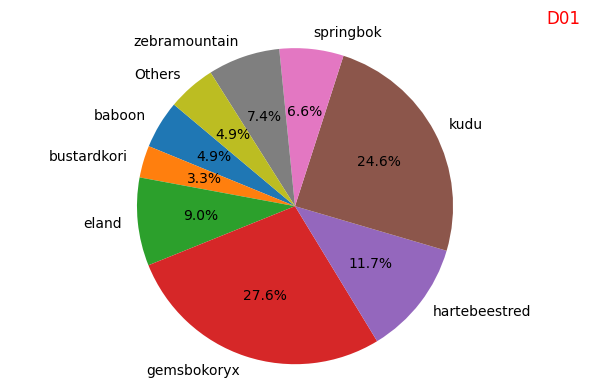

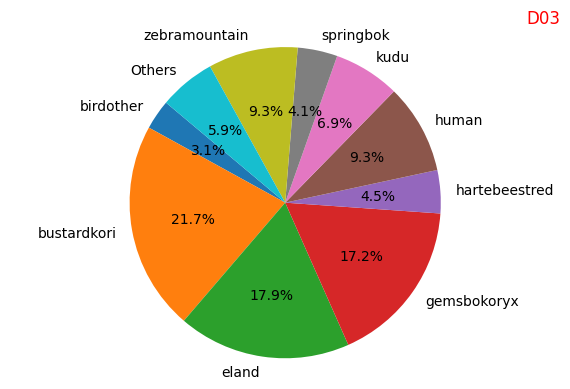

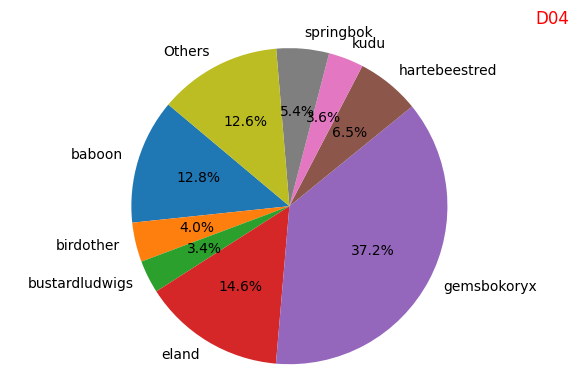

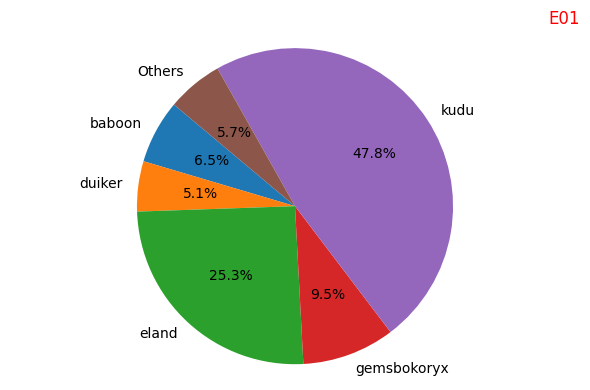

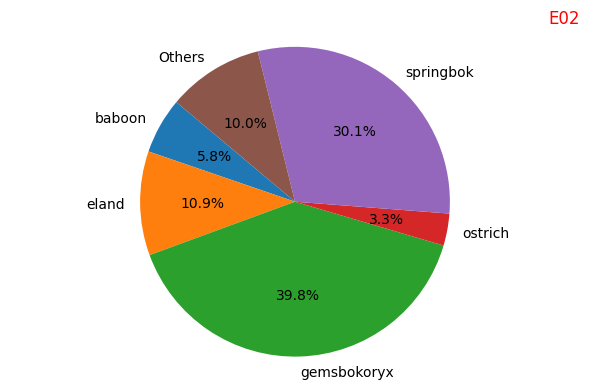

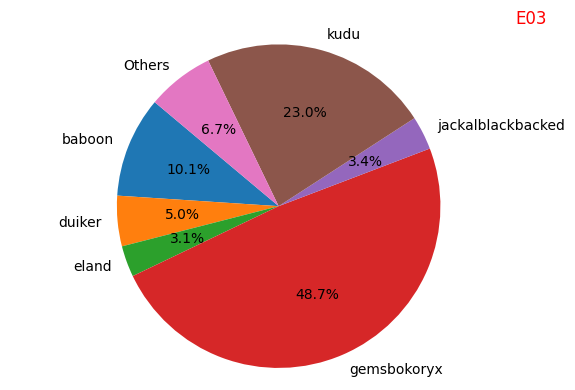

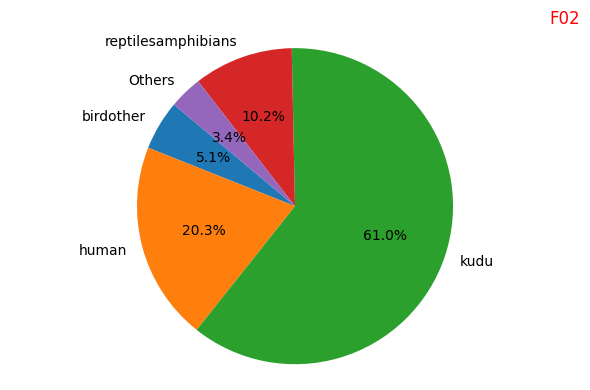

In [ ]:
# Filter annotations where category_id is not 0
filtered_annotations = [annotation for annotation in annotations if annotation['category_id'] != 0]

# Create DataFrames
df_annotations = pd.DataFrame(filtered_annotations)
df_images = pd.DataFrame(images)

# Merge annotations and images on image_id
merged_df = pd.merge(df_annotations, df_images, left_on='image_id', right_on='id', how='inner')

# Get species names from categories
species_names = {category['id']: category['name'] for category in data['categories'] if category['id'] != 0}

# Replace category_id with species names
merged_df['species'] = merged_df['category_id'].map(species_names)

# Group by camera trap and species, count the number of images
grouped_df = merged_df.groupby(['location_y', 'species']).size().unstack(fill_value=0)

# Plotting the pie chart for each camera trap
for camera_trap, species_counts in grouped_df.iterrows():
    # Calculate percentage for each species
    total_images = species_counts.sum()
    species_percentages = (species_counts / total_images) * 100
    species_percentages = species_percentages[species_percentages > 0]  # Filter out 0% species

    # Combine species with less than 3% into 'Others'
    others_percentage = species_percentages[species_percentages < 3].sum()
    species_percentages = species_percentages[species_percentages >= 3]
    species_percentages['Others'] = others_percentage

    # Plotting the pie chart
    plt.figure(figsize=(6, 4))
    species_percentages.plot(kind='pie', autopct='%1.1f%%', startangle=140)
    plt.title(camera_trap, loc='right', color='red')  # Set title in red in the top right corner
    plt.ylabel('')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.tight_layout()
    plt.show()
    plt.close()

# Task 3: Data Cleaning
After understanding the dataset better, some data cleaning will be required in order to balance it better.

Potential tasks:


*   Feature selection to optimise feature space
*   Remove images labeled as human




Megadetector

Model trained - called "MegaDetector" - to detect animals, people, and vehicles in camera trap images. It does not identify animals to the species level, it just finds them.

[Megadetector results](https://lila.science/megadetector-results-for-camera-trap-datasets/)

[Github for Megadetector](https://github.com/agentmorris/MegaDetector/blob/main/megadetector.md)

MegaDetector v4 has different confidence values than other datasets; 0.8 is a good threshold for MDv4 results, 0.2 is a good threshold for MDv5 results

In [ ]:
megadetector_results_path = '/content/snapshot-karoo/snapshot-safari_KAR_mdv5a.0.0_results.json'

# Opening JSON file containing annotations
megadetector_results_json = open(megadetector_results_path)

# returns JSON object as
# a dictionary
megadetector_results = json.load(megadetector_results_json)
print(megadetector_results['images'][0])

# retreive annotations for selected images
mdv_annotations = [x for x in megadetector_results['images'] if '{}'.format(x['file'].split('/')[-1]) in all_img_paths]
mdv_annotations[0]
print(len(mdv_annotations))

{'file': 'KAR_S1/A01/A01_R1/KAR_S1_A01_R1_IMAG00156.JPG', 'detections': [{'category': '1', 'conf': 0.832, 'bbox': [0, 0.04649, 0.1697, 0.646]}]}
1982


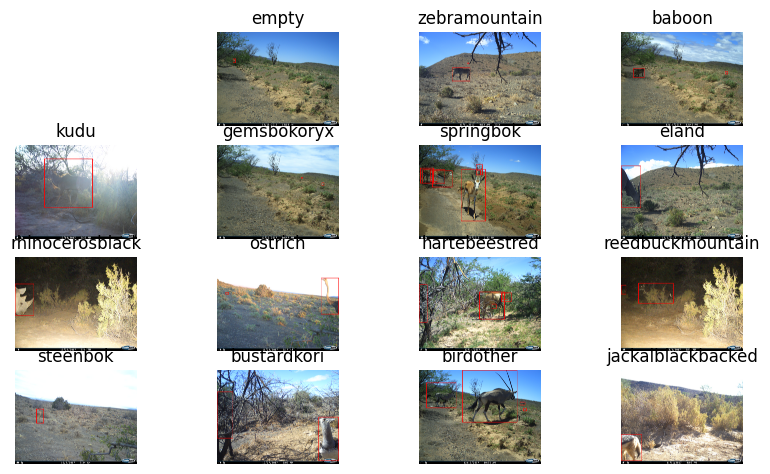

In [ ]:
# Display some images

figure = plt.figure(figsize=(10, 10))
cols, rows = 4, (len(category_vals) // 4) + 1
category_i = 0

for i in range(1, cols * rows + 1):
    if category_i < len(category_vals):
        images = df[df['category_id'] == category_vals[category_i]]
        # Display different images each time
        random_img_id = random.randint(0, len(images) - 1)
        image = read_image('/content/snapshot-karoo/{}.JPG'.format(images.iloc[random_img_id]['image_id']))
        # transform this image to PIL image
        pil_img = torchvision.transforms.ToPILImage()(image)
        # get width and height
        width, height = pil_img.size

        detections = [x['detections'] for x in mdv_annotations if x['file'] == '{}.JPG'.format(images.iloc[random_img_id]['image_id'])][0]
        if len(detections) >= 1:
            bounding_boxes = [x['bbox'] for x in detections]
            # bounding box are xmin, ymin, xmax, ymax
            boxes = [[math.trunc(x[0]*width), math.trunc(x[1]*height), math.trunc(x[2]*width) + math.trunc(x[0]*width), math.trunc(x[3]*height) + math.trunc(x[1]*height)] for x in bounding_boxes]
            box = torch.tensor(boxes, dtype=torch.int)

            # draw bounding box and fill color
            image = draw_bounding_boxes(image, box, width=10,
                                    colors="red")
            image = torchvision.transforms.ToPILImage()(image)


            figure.add_subplot(rows, cols, i)
            plt.title(annotations_data['categories'][category_vals[category_i]]['name'])
            plt.axis("off")
            plt.imshow(image)
            category_i += 1
    else:
        break

plt.show()



*   Remove images without detections, dectections with confidence score less than 0.2 and with category = 1 (this category signals an animal was detected in the image)
*   Cropping images to bounding boxes
*   Adding padding to make images square
*   Resize images to 244x244



In [ ]:
# Create the directory
#!rm -rf /content/clean

clean_path = '/content/clean'
if not os.path.exists(clean_path):
    os.mkdir(clean_path)

clean_img_annotations = []

for x in mdv_annotations:
    data_image = Image.open('/content/snapshot-karoo/{}'.format(x['file']))
    # get width and height
    width, height = data_image.size
    bbox_id = 1
    for detection in x['detections']:
        if detection['conf'] >= 0.8 and detection['category'] == '1':
            bb = detection['bbox']
            # bounding box are xmin, ymin, xmax, ymax
            bb_pixel = [math.trunc(bb[0]*width), math.trunc(bb[1]*height), math.trunc(bb[2]*width) + math.trunc(bb[0]*width), math.trunc(bb[3]*height) + math.trunc(bb[1]*height)]
            pixel_width = abs(bb_pixel[0] - bb_pixel[2])
            pixel_height = abs(bb_pixel[1] - bb_pixel[3])
            #if pixel_width >= 50 and pixel_height >= 50:
            data_image = data_image.crop((bb_pixel[0], bb_pixel[1], bb_pixel[2], bb_pixel[3]))
            result = data_image
            if pixel_width > pixel_height:
                result = Image.new(data_image.mode, (pixel_width, pixel_height + abs(pixel_width - pixel_height)), (0, 0, 0))
            elif pixel_height > pixel_width:
                result = Image.new(data_image.mode, (pixel_width + abs(pixel_width - pixel_height), pixel_height), (0, 0, 0))

            result.paste(data_image, (0, 0))
            newsize = (150, 150)
            result = result.resize(newsize)
            image_id = x['file'].split('/')[-1]
            clean_image_path = '{}/{}_{}.JPG'.format(clean_path, image_id[:-4], bbox_id)
            result.save(clean_image_path)

            image_annotation = next(([x['subject_id'], '{}_{}.JPG'.format(x['image_id'].split('/')[-1], bbox_id), x['location'], x['category_id'], x['count']] for x in annotations_data['annotations'] if '{}.JPG'.format(x['image_id'].split('/')[-1]) == image_id), None)
            clean_img_annotations.append(image_annotation)

            bbox_id += 1

In [ ]:
clean_images = os.listdir(clean_path)
print(len(clean_images), len(clean_img_annotations))

image_ids = [x[1] for x in clean_img_annotations]
outliers = [x for x in clean_images if x not in image_ids]
print(outliers)

1708 1708
[]


In [ ]:
# retreive data that will be used from annotations and load into Dataframe
#selected_clean_data = [[x['subject_id'], x['image_id'].split('/')[-1], x['location'], x['category_id'], x['count']] for x in clean_img_annotations]
clean_df = pd.DataFrame(clean_img_annotations, columns=['subject_id', 'image_id', 'camera', 'category_id', 'count'])
print(len(clean_df))
clean_df.head()

1708


,subject_id,image_id,camera,category_id,count
0,28794631,KAR_S1_A01_R1_IMAG00159_1.JPG,A01,9,1
1,28794635,KAR_S1_A01_R1_IMAG00163_1.JPG,A01,9,1
2,28794636,KAR_S1_A01_R1_IMAG00164_1.JPG,A01,9,1
3,28794643,KAR_S1_A01_R1_IMAG00171_1.JPG,A01,2,1
4,28794547,KAR_S1_A01_R1_IMAG00075_1.JPG,A01,3,4


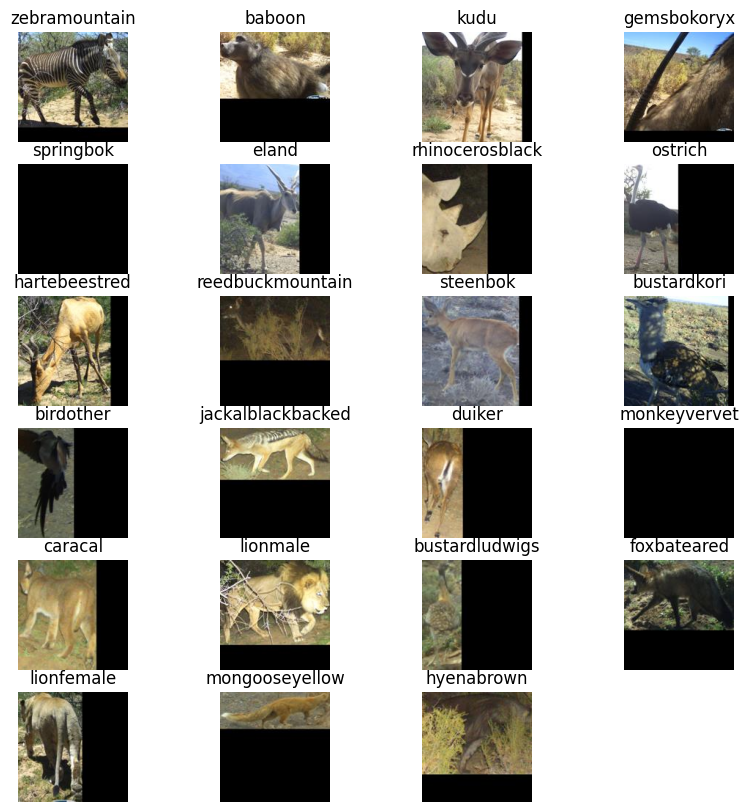

In [ ]:
# Display some images
category_vals = set(clean_df['category_id'].values)
category_vals = list(category_vals)
clean_category_names = []
clean_category_counts = []

figure = plt.figure(figsize=(10, 10))
cols, rows = 4, (len(category_vals) // 4) + 1

category_i = 0
for i in range(1, cols * rows + 1):
    if category_i < len(category_vals):
        images = clean_df[clean_df['category_id'] == category_vals[category_i]]
        clean_category_counts.append(len(images))
        clean_category_names.append(annotations_data['categories'][category_vals[category_i]]['name'])
        # Display different images each time
        random_img_id = random.randint(0, len(images) - 1)
        image = img.imread('/content/clean/{}'.format(images.iloc[random_img_id]['image_id']))
        figure.add_subplot(rows, cols, i)
        plt.title(annotations_data['categories'][category_vals[category_i]]['name'])
        plt.axis("off")
        plt.imshow(image)
        category_i += 1
    else:
        break

plt.show()

In [ ]:
clean_data_counts = {i : n for i, n in zip(clean_category_names, clean_category_counts)}
print(clean_data_counts)

{'zebramountain': 130, 'baboon': 92, 'kudu': 290, 'gemsbokoryx': 554, 'springbok': 88, 'eland': 282, 'rhinocerosblack': 1, 'ostrich': 19, 'hartebeestred': 79, 'reedbuckmountain': 1, 'steenbok': 20, 'bustardkori': 62, 'birdother': 10, 'jackalblackbacked': 15, 'duiker': 36, 'monkeyvervet': 4, 'caracal': 1, 'lionmale': 1, 'bustardludwigs': 10, 'foxbateared': 4, 'lionfemale': 5, 'mongooseyellow': 3, 'hyenabrown': 1}


In [ ]:
# Removing black images

y_target = clean_df['category_id'].values
x_input = []

for filename in [x for x in clean_df['image_id'].values]:
    x_input.append(ski.io.imread('/content/clean/{}'.format(filename)))

In [ ]:
print(len(x_input), len(y_target))
black_img_idxs = [i for i, x in enumerate(x_input) if np.sum(x) == 0]
print(len(black_img_idxs))
clean_df = clean_df.drop(black_img_idxs, axis='index')
print(len(clean_df))

1708 1708
244
1464


In [ ]:
y_target = clean_df['category_id'].values
x_input = []

for filename in [x for x in clean_df['image_id'].values]:
    x_input.append(ski.io.imread('/content/clean/{}'.format(filename)))

print(len(x_input), len(y_target))
black_img_idxs = [i for i, x in enumerate(x_input) if np.sum(x) == 0]
print(len(black_img_idxs))

1464 1464
0


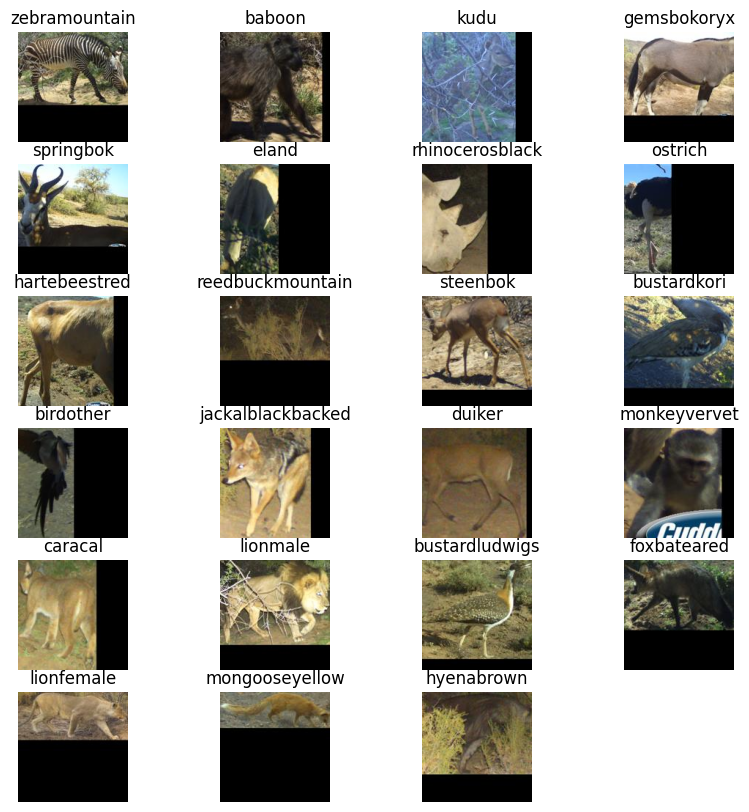

In [ ]:
# Display some images
category_vals = set(clean_df['category_id'].values)
category_vals = list(category_vals)
clean_category_names = []
clean_category_counts = []

figure = plt.figure(figsize=(10, 10))
cols, rows = 4, (len(category_vals) // 4) + 1

category_i = 0
for i in range(1, cols * rows + 1):
    if category_i < len(category_vals):
        images = clean_df[clean_df['category_id'] == category_vals[category_i]]
        clean_category_counts.append(len(images))
        clean_category_names.append(annotations_data['categories'][category_vals[category_i]]['name'])
        # Display different images each time
        random_img_id = random.randint(0, len(images) - 1)
        image = img.imread('/content/clean/{}'.format(images.iloc[random_img_id]['image_id']))
        figure.add_subplot(rows, cols, i)
        plt.title(annotations_data['categories'][category_vals[category_i]]['name'])
        plt.axis("off")
        plt.imshow(image)
        category_i += 1
    else:
        break

plt.show()

# Task 4: Data Preprocessing

Next step is to prepare the clean dataset to be used for training the Model

*   Class Balancing (remove categories with number of images below a certain threshold)
*   Data Augmentation
*   Splitting (recommend using Stratified Cross-Validation - [Stratified K Fold Cross Validation](https://www.geeksforgeeks.org/stratified-k-fold-cross-validation/))



Class balancing, removing classes with images less than 3

In [ ]:
# Define the threshold
threshold = 50

# Calculate the number of images per category
category_counts = clean_df['category_id'].value_counts()

# Filter categories with counts below the threshold
underrepresented_categories = category_counts[category_counts < threshold].index

# Remove rows corresponding to underrepresented categories
balanced_df = clean_df[~clean_df['category_id'].isin(underrepresented_categories)]

# Print the number of images per category in the balanced dataset
print(balanced_df['category_id'].value_counts())


category_id
5     451
4     281
7     209
2     105
3      89
6      71
11     71
15     62
Name: count, dtype: int64


Splitting

In [ ]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(balanced_df, test_size=0.2, shuffle=True, stratify=balanced_df['category_id'])
print(train_set.shape, test_set.shape)

(1071, 5) (268, 5)


Data augmentation

In [ ]:
import os
import torchvision.transforms as transforms
from PIL import Image

#!rm -rf /content/aug

# Define data augmentation transformations
data_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    # transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.8, 1.2))
])

# Define the path to the directory containing clean images
clean_images_dir = '/content/clean/'
aug_images_dir = '/content/aug/'

# Create the directory
if not os.path.exists(aug_images_dir):
    os.mkdir(aug_images_dir)

# Function to apply data augmentation to an image
def apply_augmentation(image):
    augmented_image = data_transforms(image)
    return augmented_image

for index, row in train_set.iterrows():
    image_path = os.path.join(clean_images_dir, row['image_id'])
    if os.path.exists(image_path):  # Check if the image file exists
        image = Image.open(image_path)
        augmented_image = apply_augmentation(image)
        # Save or use the augmented image as needed
        aug_image_path = '{}{}'.format(aug_images_dir, row['image_id'])
        augmented_image.save(aug_image_path)
    else:
        print(f"Image file not found for image ID: {row['image_id']}")


In [ ]:
y_target_train = train_set['category_id'].values
x_input_train = []

for filename in [x for x in train_set['image_id'].values]:
    x_input_train.append(ski.io.imread('/content/aug/{}'.format(filename)))

y_target_test = test_set['category_id'].values
x_input_test = []

for filename in [x for x in test_set['image_id'].values]:
    x_input_test.append(ski.io.imread('/content/clean/{}'.format(filename)))

4
kudu


array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
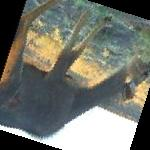

In [ ]:
# show example from training data
rand_int = random.randint(0, len(x_input_train) - 1)
print(y_target_train[rand_int])
print(annotations_data['categories'][y_target_train[rand_int]]['name'])
x_input_train[rand_int]

5
gemsbokoryx


array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[ 98,  99,  85],
        [109, 110,  96],
        [114, 115,  99],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[102, 103,  89],
        [110, 111,  97],
        [109, 110,  94],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[108, 109,  95],
        [121, 122, 108],
        [112, 113,  97],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]], dtype=uint8)
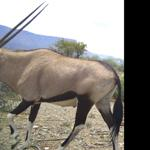

In [ ]:
# show example from test data
rand_int = random.randint(0, len(x_input_test) - 1)
print(y_target_test[rand_int])
print(annotations_data['categories'][y_target_test[rand_int]]['name'])
x_input_test[rand_int]

In [ ]:
train_data = {
    "x": x_input_train,
    "y": y_target_train
}

test_data = {
    "x": x_input_test,
    "y": y_target_test
}

train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)
train_df.head()

,x,y
0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",5
1,"[[[0, 2, 0], [0, 2, 0], [0, 2, 0], [0, 2, 0], ...",11
2,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",15
3,"[[[1, 0, 0], [1, 0, 0], [0, 0, 0], [0, 0, 0], ...",2
4,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",3


In [ ]:
print(len(train_df), len(test_df))

1071 268


In [ ]:
# Flatten image arrays
x_train_flat = [x.flatten() for x in train_df['x'].values]
x_test_flat = [x.flatten() for x in test_df['x'].values]

x_train = np.asarray(x_train_flat)
y_train = np.asarray(train_df['y'].values)
x_test = np.asarray(x_test_flat)
y_test = np.asarray(test_df['y'].values)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(1071, 67500) (1071,)
(268, 67500) (268,)


In [ ]:
x_train[0]

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [ ]:
# Feature Scaling
scaler = preprocessing.StandardScaler().fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [ ]:
x_train_scaled[0]

array([-0.13894816, -0.1251164 , -0.15245622, ..., -0.12859038,
       -0.12974208, -0.12646762])

# Task 5: Build, Train, and Test Classifier Model
Next step is to build or select a prebuilt Classifier model to perform the Classification task


*   MLPClassifier from scikit-learn which implements a multi-layer perceptron (MLP) algorithm that trains using Backpropagation
*   Convert data so that it can be loaded into model



In [ ]:
# import multiprocessing

# n_cpus = multiprocessing.cpu_count()
# n_cpus

In [ ]:
# params = {'C':[0.1 , 1, 10, 100], 'gamma':[0.0001, 0.001, 0.1, 1], 'kernel':['rbf', 'poly']}

# grid_search = GridSearchCV(classifier, params, verbose=3, cv=3)
# grid_search.fit(x_train_resampled, y_train_resampled)

# best_estimator = grid_search.best_estimator_
# print("Best estimator found by grid search:", best_estimator)

# y_pred = best_estimator.predict(x_test_scaled)
# score = metrics.accuracy_score(y_test, y_pred)
# score

In [ ]:
# classifier = svm.SVC(C=0.1, gamma=0.0001, kernel='poly', decision_function_shape='ovo')

# classifier.fit(x_train_scaled, y_train)

In [ ]:
# load optimised classifier
classifier = load('/content/snapshot-karoo/snapshot_svc.joblib')

# Best estimator found by grid search: SVC(C=0.1, decision_function_shape='ovo', gamma=0.001, kernel='poly')

In [ ]:
y_pred = classifier.predict(x_test_scaled)
score = metrics.accuracy_score(y_test, y_pred)
score

0.7649253731343284

# Task 6: Analyse and Visualise Results
Final step is to assess the accuracy of the model and visualise its performance.


*   Classification Report (Precision, Recall, F1 score)

*   Confusion Martix
*   Log loss



Accuracy

In [ ]:
from sklearn.metrics import accuracy_score

# Compute predictions on the test set
y_pred = classifier.predict(x_test_scaled)

# Calculate the accuracy of the model on the test set
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7649253731343284


Classification Report

In [ ]:
from sklearn.metrics import classification_report

# Generate classification report
classification_rep = classification_report(y_test, y_pred)

# Show classification report
print("Classification Report:")
print(classification_rep)


Classification Report:
              precision    recall  f1-score   support

           2       0.88      0.67      0.76        21
           3       1.00      0.72      0.84        18
           4       0.75      0.54      0.63        56
           5       0.70      0.93      0.80        90
           6       0.88      0.50      0.64        14
           7       0.83      0.81      0.82        42
          11       0.69      0.79      0.73        14
          15       0.86      0.92      0.89        13

    accuracy                           0.76       268
   macro avg       0.82      0.73      0.76       268
weighted avg       0.78      0.76      0.76       268



Confusion Matrix

In [ ]:
# given category id and name
categories = [
    {"id": 0, "name": "empty"},
    {"id": 1, "name": "human"},
    {"id": 2, "name": "zebramountain"},
    {"id": 3, "name": "baboon"},
    {"id": 4, "name": "kudu"},
    {"id": 5, "name": "gemsbokoryx"},
    {"id": 6, "name": "springbok"},
    {"id": 7, "name": "eland"},
    {"id": 8, "name": "rhinocerosblack"},
    {"id": 9, "name": "ostrich"},
    {"id": 10, "name": "rhebokgrey"},
    {"id": 11, "name": "hartebeestred"},
    {"id": 12, "name": "reedbuckmountain"},
    {"id": 13, "name": "steenbok"},
    {"id": 14, "name": "zebraburchells"},
    {"id": 15, "name": "bustardkori"},
    {"id": 16, "name": "birdother"},
    {"id": 17, "name": "jackalblackbacked"},
    {"id": 18, "name": "duiker"},
    {"id": 19, "name": "monkeyvervet"},
    {"id": 20, "name": "hare"},
    {"id": 21, "name": "wildebeestblue"},
    {"id": 22, "name": "caracal"},
    {"id": 23, "name": "lionmale"},
    {"id": 24, "name": "tortoise"},
    {"id": 25, "name": "foxcape"},
    {"id": 26, "name": "rabbitriverine"},
    {"id": 27, "name": "porcupine"},
    {"id": 28, "name": "bustardludwigs"},
    {"id": 29, "name": "foxbateared"},
    {"id": 30, "name": "mongoosesmallcapegrey"},
    {"id": 31, "name": "reptilesamphibians"},
    {"id": 32, "name": "birdsofprey"},
    {"id": 33, "name": "klipspringer"},
    {"id": 34, "name": "meerkatsuricate"},
    {"id": 35, "name": "lionfemale"},
    {"id": 36, "name": "mongooseyellow"},
    {"id": 37, "name": "hyenabrown"}
]

# Map category ID to category name
category_id_to_name = {category["id"]: category["name"] for category in categories}

# given category id
given_category_ids = [2,3,4,5,6,7,11,15]

# Get the category name corresponding to the given category ID
category_names = [category_id_to_name[category_id] for category_id in given_category_ids]

print(category_names)


['zebramountain', 'baboon', 'kudu', 'gemsbokoryx', 'springbok', 'eland', 'hartebeestred', 'bustardkori']


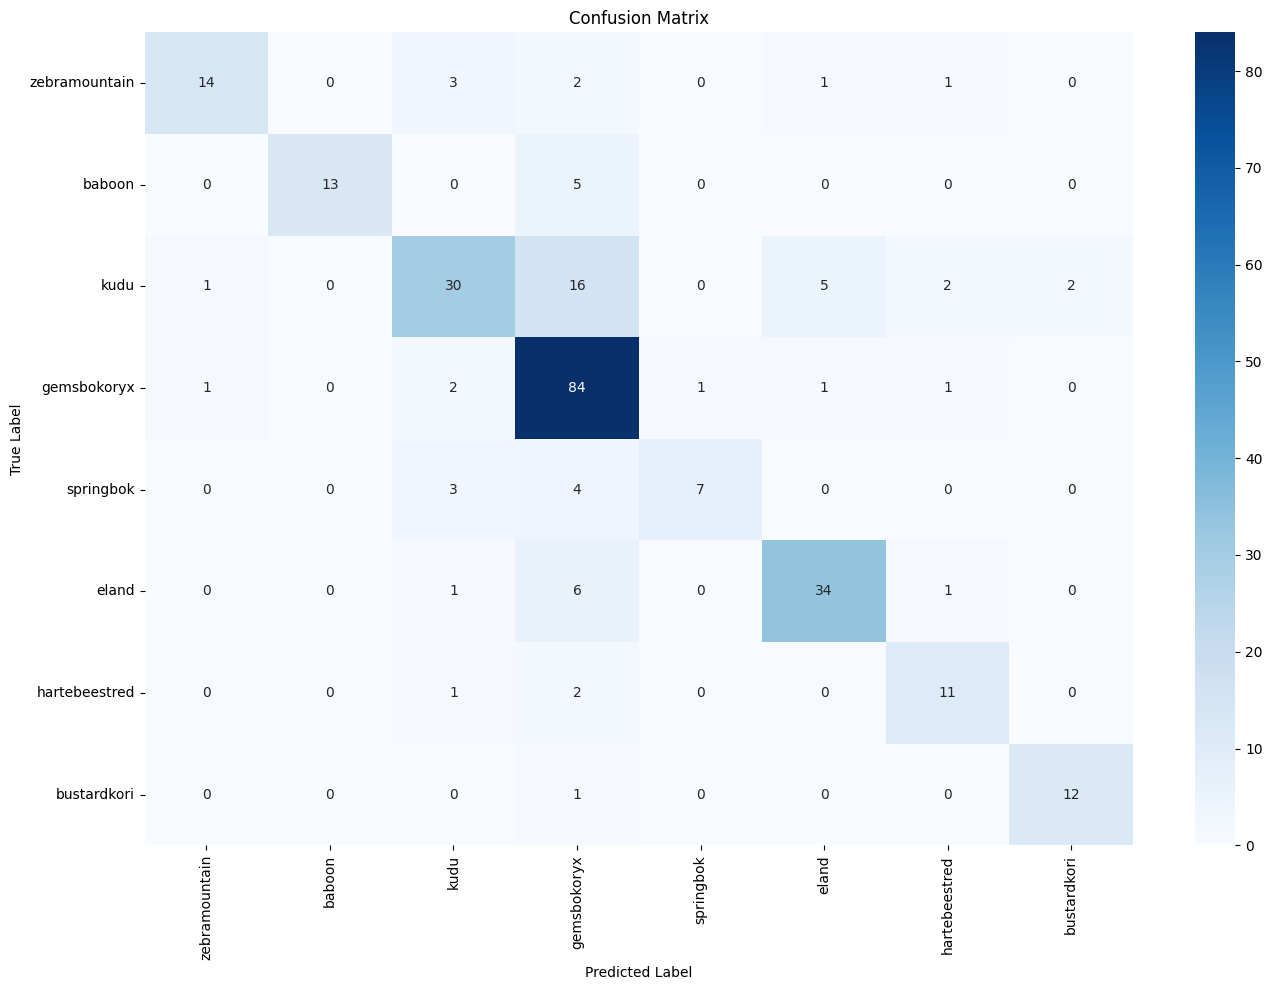

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(14, 10))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=category_names, yticklabels=category_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

log loss

In [ ]:
from sklearn.metrics import log_loss

# Calculate the log loss of the model on the test set
logloss = log_loss(y_test, classifier.predict_proba(x_test_scaled))

# Print log loss
print("Log Loss:", logloss)


Log Loss: 1.0552200929498017
